In [1]:
import numpy as np
import pandas as pd
import pylab as plt

import seaborn as sns
import pickle

import warnings

warnings.filterwarnings('ignore')

from prophet import Prophet
from prophet import diagnostics
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

## Load Data

In [2]:
cons_df = pd.read_csv('./../../datasets/prod-region.csv', sep=';')

In [4]:
cons_df.loc[cons_df['Horodate'] > '2020-06-01'].groupby('Horodate').sum().iloc[::-1]

Code région  Nb points injection  \
Horodate                                                      
2021-12-31T23:30:00+01:00          600               139587   
2021-12-31T23:00:00+01:00          600               139587   
2021-12-31T22:30:00+01:00          600               139587   
2021-12-31T22:00:00+01:00          600               139587   
2021-12-31T21:30:00+01:00          600               139587   
...                                ...                  ...   
2020-06-01T02:00:00+02:00          600               115019   
2020-06-01T01:30:00+02:00          600               115019   
2020-06-01T01:00:00+02:00          600               115019   
2020-06-01T00:30:00+02:00          600               115019   
2020-06-01T00:00:00+02:00          600               115019   

                           Total énergie injectée (Wh)  \
Horodate                                                 
2021-12-31T23:30:00+01:00                          0.0   
2021-12-31T23:00:00+01:00                          0.0   
2021-12-31T22:30:00+01:00                       3497.0   
2021-12-31T22:00:00+01:00                       2415.0   
2021-12-31T21:30:00+01:00                       2240.0   
...                                                ...   
2020-06-01T02:00:00+02:00                          0.0   
2020-06-01T01:30:00+02:00                          0.0   
2020-06-01T01:00:00+02:00                          0.0   
2020-06-01T00:30:00+02:00                          0.0   
2020-06-01T00:00:00+02:00                          0.0   

                           Courbe Moyenne n°1 (Wh)  Courbe Moyenne n°2 (Wh)  \
Horodate                                                                      
2021-12-31T23:30:00+01:00                      0.0                      0.0   
2021-12-31T23:00:00+01:00                      0.0                      0.0   
2021-12-31T22:30:00+01:00                      0.0                      0.0   
2021-12-31T22:00:00+01:00                      3.0                      0.0   
2021-12-31T21:30:00+01:00                      0.0                      0.0   
...                                            ...                      ...   
2020-06-01T02:00:00+02:00                      0.0                      0.0   
2020-06-01T01:30:00+02:00                      0.0                      0.0   
2020-06-01T01:00:00+02:00                      0.0                      0.0   
2020-06-01T00:30:00+02:00                      0.0                      0.0   
2020-06-01T00:00:00+02:00                      0.0                      0.0   

                           Courbe Moyenne n°1 + n°2 (Wh)  
Horodate                                                  
2021-12-31T23:30:00+01:00                            0.0  
2021-12-31T23:00:00+01:00                            0.0  
2021-12-31T22:30:00+01:00                            0.0  
2021-12-31T22:00:00+01:00                            1.0  
2021-12-31T21:30:00+01:00                            0.0  
...                                                  ...  
2020-06-01T02:00:00+02:00                            0.0  
2020-06-01T01:30:00+02:00                            0.0  
2020-06-01T01:00:00+02:00                            0.0  
2020-06-01T00:30:00+02:00                            0.0  
2020-06-01T00:00:00+02:00                            0.0  

[27794 rows x 6 columns]

In [5]:
#reduce information
cons_df.drop(['Région', 'Code région', 'Plage de puissance injection', 'Filière de production', 'Nb points injection',
         'Courbe Moyenne n°1 + n°2 (Wh)', 'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
         'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
         'Indice représentativité Courbe n°1 + n°2 (%)', 'Jour max du mois (0/1)', 'Semaine max du mois (0/1)'],
        axis='columns', inplace=True)
cons_df.dropna(inplace=True)
cons_df['Horodate'] = pd.to_datetime(cons_df['Horodate'].values, utc=True)
cons_df['Horodate'] = cons_df['Horodate'].dt.tz_localize(None)
cons_df = cons_df.loc[cons_df['Horodate'] > '2020-06-01']
cons_df = cons_df.groupby('Horodate').sum().iloc[::-1]
cons_df = cons_df.reset_index()
cons_df.head(100)

Horodate  Total énergie injectée (Wh)
0  2021-12-31 22:30:00                          0.0
1  2021-12-31 22:00:00                          0.0
2  2021-12-31 21:30:00                       3497.0
3  2021-12-31 21:00:00                       2415.0
4  2021-12-31 20:30:00                       2240.0
..                 ...                          ...
95 2021-12-29 23:00:00                          0.0
96 2021-12-29 22:30:00                          0.0
97 2021-12-29 22:00:00                          0.0
98 2021-12-29 21:30:00                       2842.0
99 2021-12-29 21:00:00                       1725.0

[100 rows x 2 columns]

In [6]:
#area graph (Date Vs Price)
import plotly.express as px
px.scatter(cons_df,
           x='Horodate',
           y='Total énergie injectée (Wh)')

## Simple Prophet Model

### Acquire and clean data

In [9]:
# Rename columns to fit the Prophet format
data = cons_df.rename(columns={'Horodate':'ds', 'Total énergie injectée (Wh)':'y'})
#data.to_csv('data.csv')

# Standardize the data
colx = ['y']

data_st = (data[colx] - data[colx].mean()) / data[colx].std()
#data_st = data
data_st['ds'] = data['ds']
data_st['cap'] = data_st['y'].max()*1.2
data_st['floor'] = 0
#data_st.to_csv('data_st.csv')

In [10]:
data.y.std(), data.y.mean(), data_st.y.max()*1.2

(471421360.85562223, 328610356.3166721, 4.080539845136828)

## Train the model

In [11]:
# Create instance of model and train
prophet1 = Prophet(daily_seasonality=True,
                   weekly_seasonality=False,
                   yearly_seasonality=True,
                   seasonality_mode='additive',
                   changepoint_prior_scale=0.001,
                   seasonality_prior_scale=20,
                   growth="logistic")

prophet1.fit(data_st)

prophet1.stan_backend.logger = None
with open("prophet1.pickle", "wb") as f:
    pickle.dump(prophet1, f)

### Forecast future energy production

In [12]:
n_months = 12
n_days = n_months * 30
n_hours = (n_days * 24) * 2
print("We want to forecast:\n - {0} months, which is\n - {1} days, which is\n - {2} half-hour".format(n_months, n_days, n_hours))

# Create dataframe containing future energy production predictions
pred_period1 = prophet1.make_future_dataframe(periods=n_hours, freq="30min")
pred_period1['cap'] = data_st['y'].max()*1.2
pred_period1['floor'] = 0

preds1 = prophet1.predict(pred_period1)
#preds1.to_csv('preds1.csv')

We want to forecast:
 - 12 months, which is
 - 360 days, which is
 - 17280 half-hour


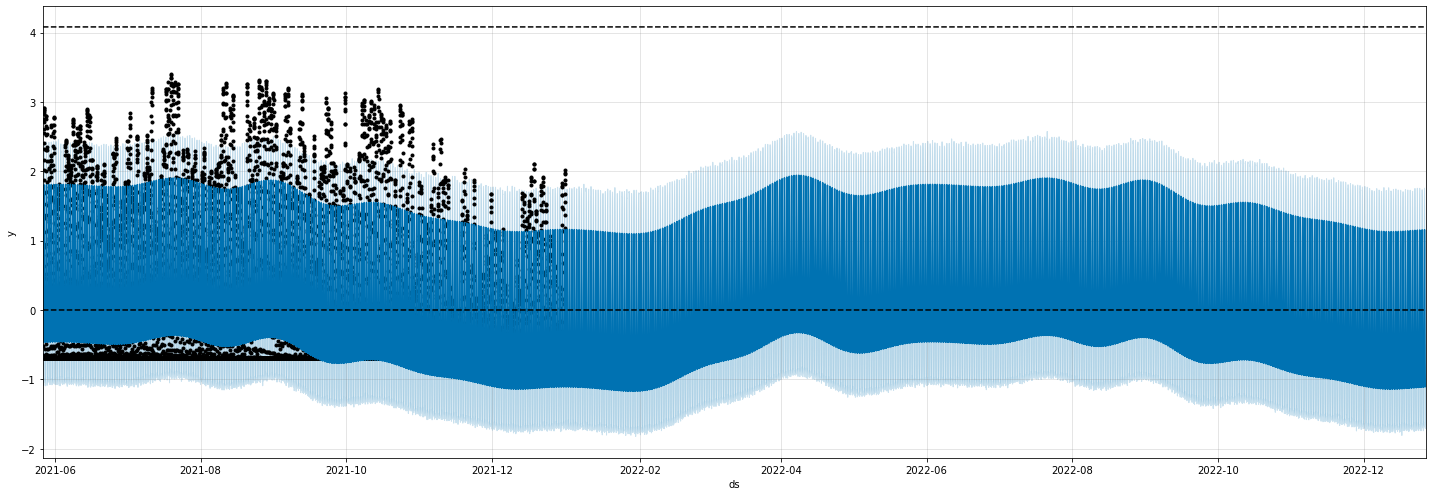

In [13]:
backtrack = (1 * 12 * 30 * 24) * 2
backtrack = int(backtrack)

fig = prophet1.plot(preds1[-backtrack - n_hours:], figsize=(20, 7))
plt.plot(data_st.ds[-backtrack:], data_st.y[-backtrack:], '--')
plt.xlim(data_st.ds.values[-backtrack], preds1.ds.values[-1] + np.timedelta64())
fig.show()

fig.savefig('prophet1_predictions.png')

In [14]:
def make_plot_block(preds, start, end, ax=None, xlabel='days'):

    # Truncate dataframes to only relevant portions
    actual = data_st.loc[(data_st.ds > start) & (data_st.ds < end), :].set_index('ds')
    forecast = preds.loc[(preds.ds > start) & (preds.ds < end), :].set_index('ds')

    actual.loc[:,'y'].plot(color='k', label='observations', ax=ax)
    forecast.loc[:,'yhat'].plot(color='steelblue', label='forecasts', ls='--', lw=3, ax=ax)
    ax.fill_between(forecast.index, forecast.loc[:,'yhat_lower'], forecast.loc[:,'yhat_upper'], color='steelblue', alpha=0.3)

    ax.grid(ls=':')
    ax.legend(fontsize=15)

    if xlabel == 'days':
        labels = [t.strftime('%b %d') for t in forecast.index]
    else:
        labels = [t.strftime("%b '") + t.strftime("%Y")[-2:] for t in forecast.index]
    ax.set_xticklabels(labels[::len(labels)//10], fontsize='large')

    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

    ax.set_ylabel('Energy Production', fontsize=15)
    ax.set_title(start + ' to ' + end, fontsize='xx-large')

def plot_seasons(preds, year):
    fig, ax = plt.subplots(4, 1, figsize=(20, 28))

    start = year + '-01-01'
    end = year + '-01-15'
    make_plot_block(preds, start, end, ax=ax[0], xlabel='days')

    start = year + '-04-01'
    end = year + '-04-15'
    make_plot_block(preds, start, end, ax=ax[1], xlabel='days')

    start = year + '-07-01'
    end = year + '-07-15'
    make_plot_block(preds, start, end, ax=ax[2], xlabel='days')

    start = year + '-10-01'
    end = year + '-10-15'
    make_plot_block(preds, start, end, ax=ax[3], xlabel='days')

    fig.subplots_adjust(hspace=0.35)
    return fig

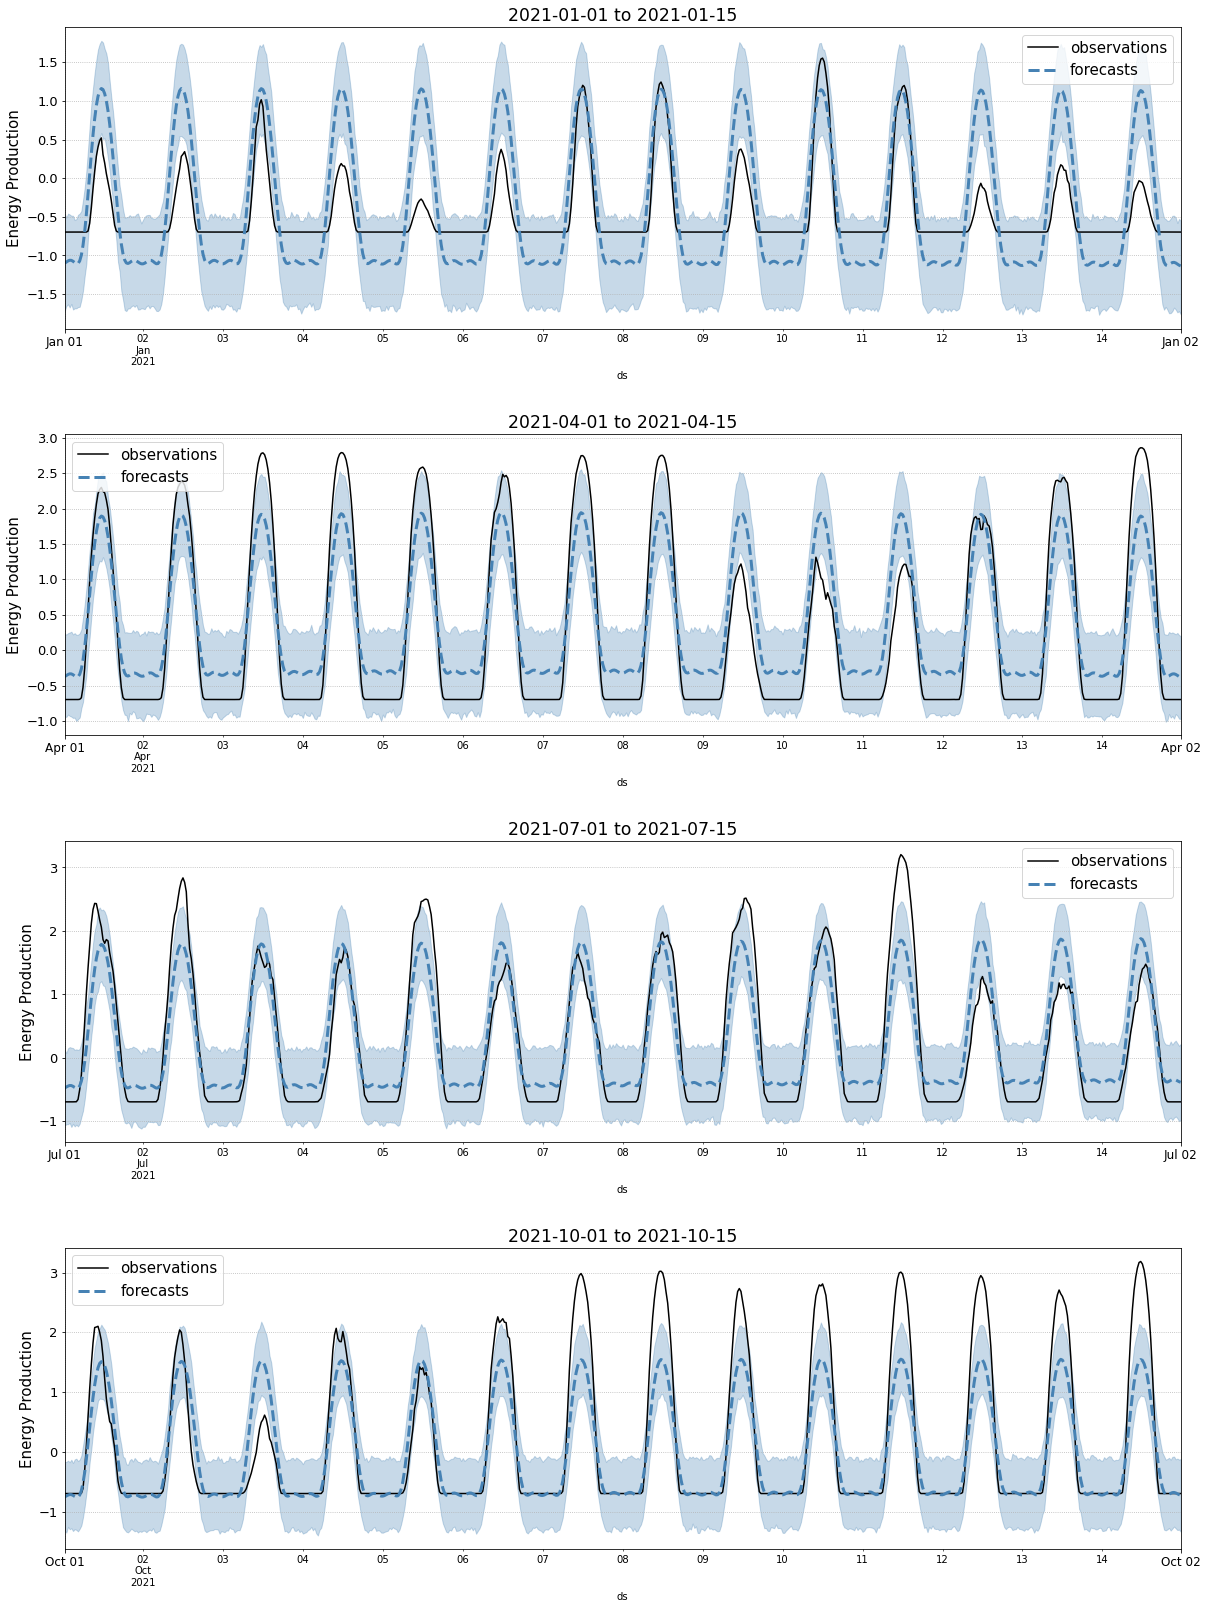

In [15]:
fig = plot_seasons(preds1, '2021')
fig.savefig('season_preds1.png')

### Examine the seasonality component of the model

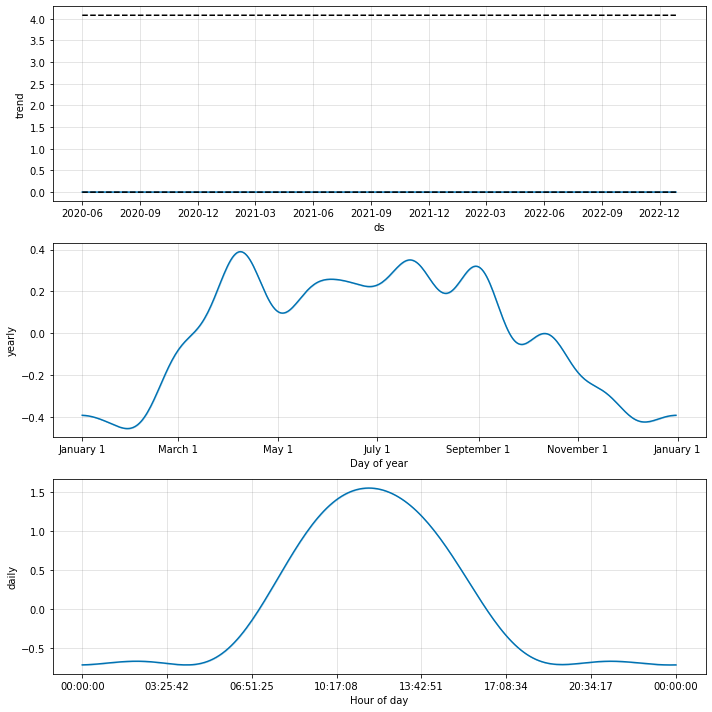

In [16]:
fig = prophet1.plot_components(preds1, figsize=(10, 10))
fig.savefig('prophet1_components.png')
fig.show()

### Model Validation

In [17]:
def mape(y_pred, y_true):
    ''' Mean average percent error statistic '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_pred - y_true) / np.abs(y_true))

def unstandardize(y):
    return y * data.y.std() + data.y.mean()

In [18]:
result1_cv = diagnostics.cross_validation(prophet1, horizon="90 days")
result1_cv.to_csv('result1_cv.csv')

# Unstandardize the results
result1_cv_adj = result1_cv.copy()
result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] *= data.y.std()
result1_cv_adj[['yhat', 'yhat_lower', 'yhat_upper', 'y']] += data.y.mean()
#check out forecast
result1_cv_adj.to_csv('result1_cv_adj.csv')

INFO:prophet:Making 3 forecasts with cutoffs between 2021-07-04 22:30:00 and 2021-10-02 22:30:00


  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
for col in ['yhat', 'yhat_lower', 'yhat_upper', 'y']:
    result1_cv_adj[col].clip(lower=0.0)

In [20]:
result1_day = result1_cv_adj.groupby(by=[result1_cv_adj.ds.dt.day,
                                         result1_cv_adj.ds.dt.month,
                                         result1_cv_adj.ds.dt.year]).sum()
result1_month = result1_cv_adj.groupby(by=[result1_cv_adj.ds.dt.month,
                                           result1_cv_adj.ds.dt.year]).sum()
result1_ag = result1_cv_adj.groupby('cutoff').sum()

print("Monthly mean average percent error: {:.2%}".format(mape(result1_month.yhat, result1_month.y)))
print("3-month mean average percent error: {:.2%}".format(mape(result1_ag.yhat, result1_ag.y)))

Monthly mean average percent error: 18.63%
3-month mean average percent error: 16.80%


In [21]:
result1_cv_adj[['ds', 'yhat']]

ds          yhat
0     2021-07-04 23:00:00  1.274465e+08
1     2021-07-04 23:30:00  1.233077e+08
2     2021-07-05 00:00:00  1.228770e+08
3     2021-07-05 00:30:00  1.263448e+08
4     2021-07-05 01:00:00  1.323520e+08
...                   ...           ...
12955 2021-12-31 20:30:00 -2.204921e+08
12956 2021-12-31 21:00:00 -2.136812e+08
12957 2021-12-31 21:30:00 -2.112899e+08
12958 2021-12-31 22:00:00 -2.139201e+08
12959 2021-12-31 22:30:00 -2.200349e+08

[12960 rows x 2 columns]

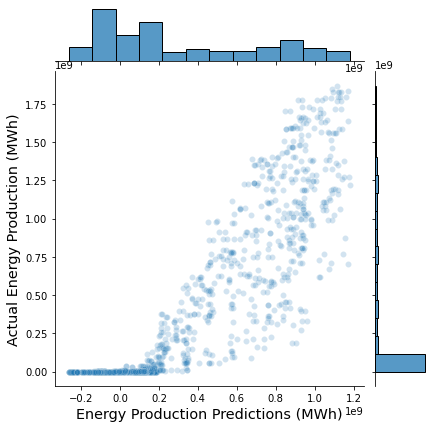

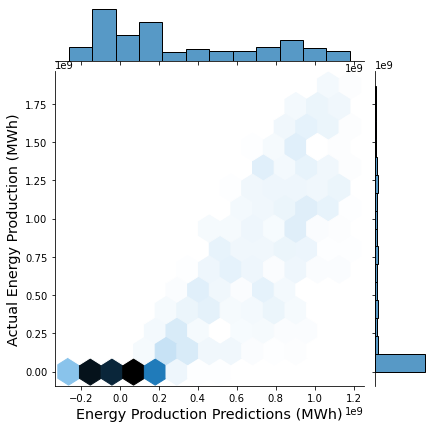

In [22]:
step = 10
grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_scatter1.png')

grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], kind='hex')
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_hex1.png')

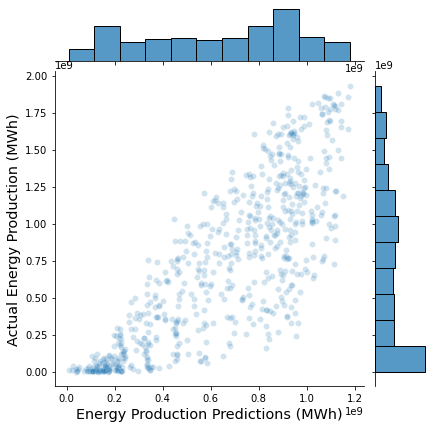

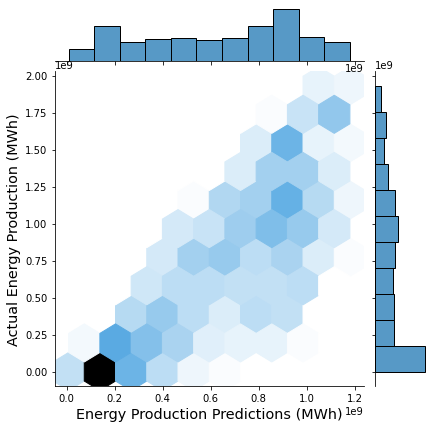

In [23]:
# remove all records where yhat is 0
result1_cv_adj = result1_cv_adj[result1_cv_adj.yhat > 0.5e6]
result1_cv_adj = result1_cv_adj[result1_cv_adj.y > 0.5e6]
step = 10
grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], alpha=0.2)
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_scatter1.png')

grid = sns.jointplot(result1_cv_adj.yhat[::step], result1_cv_adj.y[::step], kind='hex')
grid.set_axis_labels('Energy Production Predictions (MWh)', 'Actual Energy Production (MWh)', fontsize='x-large')
grid.savefig('joint_hex1.png')

In [24]:
def plot_residuals(errs, fig=None, ax=None, display=True):
    if not fig:
        fig, ax = plt.subplots(figsize=(7, 7))
    sns.distplot(errs, bins=50, ax=ax)
    ax.set_title('Histogram of Prediction Residuals (Test Set)', fontsize='xx-large')
    plt.axvline(errs.median(), color='k', label='median')
    ax.set_xlabel('Error (Wh)', fontsize='xx-large')
    ax.set_yticks([])

    if display:
        ax.text(0.05, 0.9, "Median = {:+4.2f} Wh".
                format((errs).median()),
                fontsize=14, transform=ax.transAxes)
    return fig

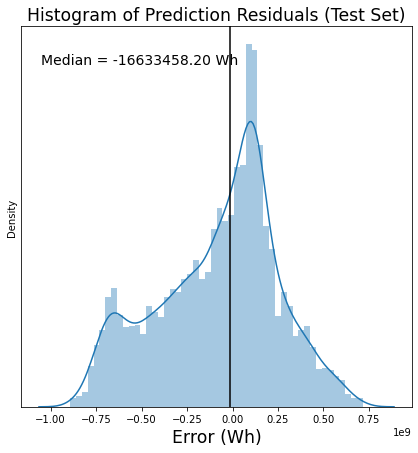

In [25]:
errs1 = result1_cv_adj.yhat - result1_cv_adj.y      # Units are now Wh, not standardized
fig = plot_residuals(errs1)
fig.savefig('residuals1_hist.png')
fig.show()

In [26]:
print('The median error was {0:.2%} of the mean energy demand.'.format(errs1.median() / result1_cv_adj.y.mean()))

The median error was -2.33% of the mean energy demand.


Text(0.05, 0.1, 'Min Error = -893443630.08 Wh')

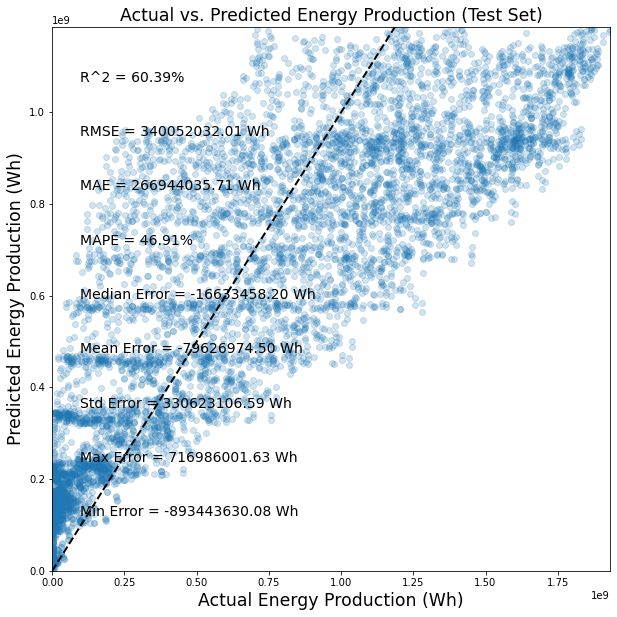

In [27]:
# Show the error between the actual and predicted values
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(result1_cv_adj.y, result1_cv_adj.yhat, alpha=0.2)
ax.set_title('Actual vs. Predicted Energy Production (Test Set)', fontsize='xx-large')
ax.set_xlabel('Actual Energy Production (Wh)', fontsize='xx-large')
ax.set_ylabel('Predicted Energy Production (Wh)', fontsize='xx-large')
ax.set_xlim(0, result1_cv_adj.y.max())
ax.set_ylim(0, result1_cv_adj.yhat.max())
ax.plot([0, result1_cv_adj.y.max()], [0, result1_cv_adj.y.max()], 'k--', lw=2)
ax.text(0.05, 0.9, "R^2 = {:.2%}".format(r2_score(result1_cv_adj.y, result1_cv_adj.yhat)),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.8, "RMSE = {:.2f} Wh".format(np.sqrt(mean_squared_error(result1_cv_adj.y, result1_cv_adj.yhat))),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.7, "MAE = {:.2f} Wh".format(mean_absolute_error(result1_cv_adj.y, result1_cv_adj.yhat)),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.6, "MAPE = {:.2%}".format(mape(result1_cv_adj.y, result1_cv_adj.yhat)),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.5, "Median Error = {:.2f} Wh".format(errs1.median()),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.4, "Mean Error = {:.2f} Wh".format(errs1.mean()),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.3, "Std Error = {:.2f} Wh".format(errs1.std()),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.2, "Max Error = {:.2f} Wh".format(errs1.max()),
        fontsize=14, transform=ax.transAxes)
ax.text(0.05, 0.1, "Min Error = {:.2f} Wh".format(errs1.min()),
        fontsize=14, transform=ax.transAxes)